In [2]:
# Import libraries
import pandas as pd
import datetime as dt
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import collections
from collections import Counter
from collections import defaultdict
import itertools

from scipy import stats
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
df =pd.read_csv(r"C:\Users\karan\Downloads\ML Advanced Exam Paper\ML Advanced Exam Paper\Dataset\RFM Dataset\RFM data.csv")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [4]:
df.shape

(392735, 9)

In [5]:
df.nunique()

InvoiceNo      18046
StockCode       3629
Description     3837
Quantity         117
InvoiceDate    16859
UnitPrice        289
CustomerID      4298
Country           37
TotalPrice      2125
dtype: int64

In [6]:
df.describe()

,InvoiceNo,Quantity,UnitPrice,CustomerID,TotalPrice
count,392735.000000,392735.000000,392735.000000,392735.000000,392735.000000
mean,560624.318859,10.242645,2.787111,15300.835136,18.246537
std,13113.076784,16.172009,2.704759,1709.095993,32.558080
min,536365.000000,1.000000,0.120000,12347.000000,0.120000
25%,549233.000000,2.000000,1.250000,13975.000000,4.680000
50%,561894.000000,5.000000,1.950000,15159.000000,11.700000
75%,572103.000000,12.000000,3.750000,16800.000000,19.500000
max,581587.000000,147.000000,19.960000,18287.000000,1914.240000


### Q8 Calculate the  a) recency (R), b)  frequency (F) c)  monetary value (M) for each customer based on the given dataset? 

In [7]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Split datetime from InvoiceDate
df['Date'] = df['InvoiceDate'].dt.date
df['Time'] = df['InvoiceDate'].dt.time

# Remove InvoiceDate column
df.drop(['InvoiceDate'], axis=1, inplace=True)
df.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,TotalPrice,Date,Time
0,536365,85123A,white hanging heart t-light holder,6,2.55,17850.0,United Kingdom,15.30,2010-12-01,08:26:00
1,536365,71053,white metal lantern,6,3.39,17850.0,United Kingdom,20.34,2010-12-01,08:26:00
2,536365,84406B,cream cupid hearts coat hanger,8,2.75,17850.0,United Kingdom,22.00,2010-12-01,08:26:00
3,536365,84029G,knitted union flag hot water bottle,6,3.39,17850.0,United Kingdom,20.34,2010-12-01,08:26:00
4,536365,84029E,red woolly hottie white heart.,6,3.39,17850.0,United Kingdom,20.34,2010-12-01,08:26:00


In [8]:
df.nunique()


InvoiceNo      18046
StockCode       3629
Description     3837
Quantity         117
UnitPrice        289
CustomerID      4298
Country           37
TotalPrice      2125
Date             305
Time             736
dtype: int64

In [9]:
df['InvoiceNo'].value_counts().head()

InvoiceNo
576339    540
579196    527
580727    522
578270    440
573576    432
Name: count, dtype: int64

In [10]:
orders = df.groupby(['InvoiceNo', 'Date', 'CustomerID']).agg({'TotalPrice': lambda x: x.sum()}).reset_index()
orders.head()

,InvoiceNo,Date,CustomerID,TotalPrice
0,536365,2010-12-01,17850.0,139.12
1,536366,2010-12-01,17850.0,22.20
2,536367,2010-12-01,13047.0,278.73
3,536368,2010-12-01,13047.0,70.05
4,536369,2010-12-01,13047.0,17.85


To simulate an analysis I am doing in real time by setting the NOW date at one day after the last purchase. This date will be used as a reference to calculate the Recency score.

In [11]:
NOW = orders['Date'].max() + timedelta(days=1)
NOW

datetime.date(2011, 12, 10)

In [12]:
period = 365

Calculate the Recency, Frequency and Monetary Value of each customers
To make things easier, I am going to add a column with the number of days between the purchase and now. To find the Recency values, I will just have to find the minimum of this column for each customer.

In [13]:
orders['DaysSinceOrder'] = orders['Date'].apply(lambda x: (NOW - x).days)

In [14]:
aggr = {
    'DaysSinceOrder': lambda x: x.min(),  # the number of days since last order (Recency)
    'Date': lambda x: len([d for d in x if d >= NOW - timedelta(days=period)]), # the total number of orders in the last period (Frequency)
}
rfm = orders.groupby('CustomerID').agg(aggr).reset_index()
rfm.rename(columns={'DaysSinceOrder': 'Recency', 'Date': 'Frequency'}, inplace=True)
rfm.head()

,CustomerID,Recency,Frequency
0,12347.0,3,6
1,12348.0,76,4
2,12349.0,19,1
3,12350.0,311,1
4,12352.0,37,7


In [15]:
rfm['Monetary'] = rfm['CustomerID'].apply(lambda x: orders[(orders['CustomerID'] == x) & \
                                                           (orders['Date'] >= NOW - timedelta(days=period))]\
                                                           ['TotalPrice'].sum())
rfm

,CustomerID,Recency,Frequency,Monetary
0,12347.0,3,6,3348.61
1,12348.0,76,4,1437.24
2,12349.0,19,1,1417.60
3,12350.0,311,1,294.40
4,12352.0,37,7,1385.74
...,...,...,...,...
4293,18280.0,278,1,180.60
4294,18281.0,181,1,80.82
4295,18282.0,8,2,178.05
4296,18283.0,4,16,2088.93


Calculate the R, F and M scores
At this point, I have the values for Recency, Frequency and Monetary parameters. Each customer will get a note between 1 and 5 for each parameter.
We can do this by setting ranges based on expected behavior5 days

We could also use quintiles. Each quintiles contains 20% of the population. Using quintiles is more flexible as the ranges will adapt to the data and would work across different industries or if there's any change in expected customer behavior.
I am going to use the quintiles method. First, I get the quintiles for each 

Answer- 'Recency': {0.2: 15.0, 0.4: 33.0, 0.6: 72.0, 0.8: 180.0},
 'Frequency': {0.2: 1.0, 0.4: 2.0, 0.6: 3.0, 0.8: 5.0},
 'Monetary': {0.2: 217.2039999999999 
  0.4: 432.058000000000
  0.6: 855.4539999999,
  0.8: 1871192}}parameter.

In [16]:
quintiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'Recency': {0.2: 15.0, 0.4: 33.0, 0.6: 72.0, 0.8: 180.0},
 'Frequency': {0.2: 1.0, 0.4: 2.0, 0.6: 3.0, 0.8: 5.0},
 'Monetary': {0.2: 217.20399999999998,
  0.4: 432.05800000000005,
  0.6: 855.4539999999996,
  0.8: 1871.192}}

### Q9 Calculate RFM scores. Each customer will get a note between 1 and 5 for each parameter for Recency(R), Frequency(F) and Monetary value(M) ys 

In [17]:
def r_score(x):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1

def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5    

In [18]:
rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: fm_score(x, 'Frequency'))
rfm['M'] = rfm['Monetary'].apply(lambda x: fm_score(x, 'Monetary'))

In [19]:
rfm['RFM Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM Score
0,12347.0,3,6,3348.61,5,5,5,555
1,12348.0,76,4,1437.24,2,4,4,244
2,12349.0,19,1,1417.60,4,1,4,414
3,12350.0,311,1,294.40,1,1,2,112
4,12352.0,37,7,1385.74,3,5,4,354


### Segment the customers based on their RFM scores using the dataset?

In [22]:
segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'can\'t loose',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2-3]': 'potential loyalists',
    r'5[4-5]': 'champions'
}

rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM Score,Segment
0,12347.0,3,6,3348.61,5,5,5,555,champions
1,12348.0,76,4,1437.24,2,4,4,244,at risk
2,12349.0,19,1,1417.60,4,1,4,414,promising
3,12350.0,311,1,294.40,1,1,2,112,hibernating
4,12352.0,37,7,1385.74,3,5,4,354,loyal customers


In [28]:
rfm['Segment'].unique()

array(['champions', 'at risk', 'promising', 'hibernating',
       'loyal customers', 'potential loyalists', 'about to sleep',
       'need attention', 'new customers', "can't loose"], dtype=object)

### Visualize the RFM segments.

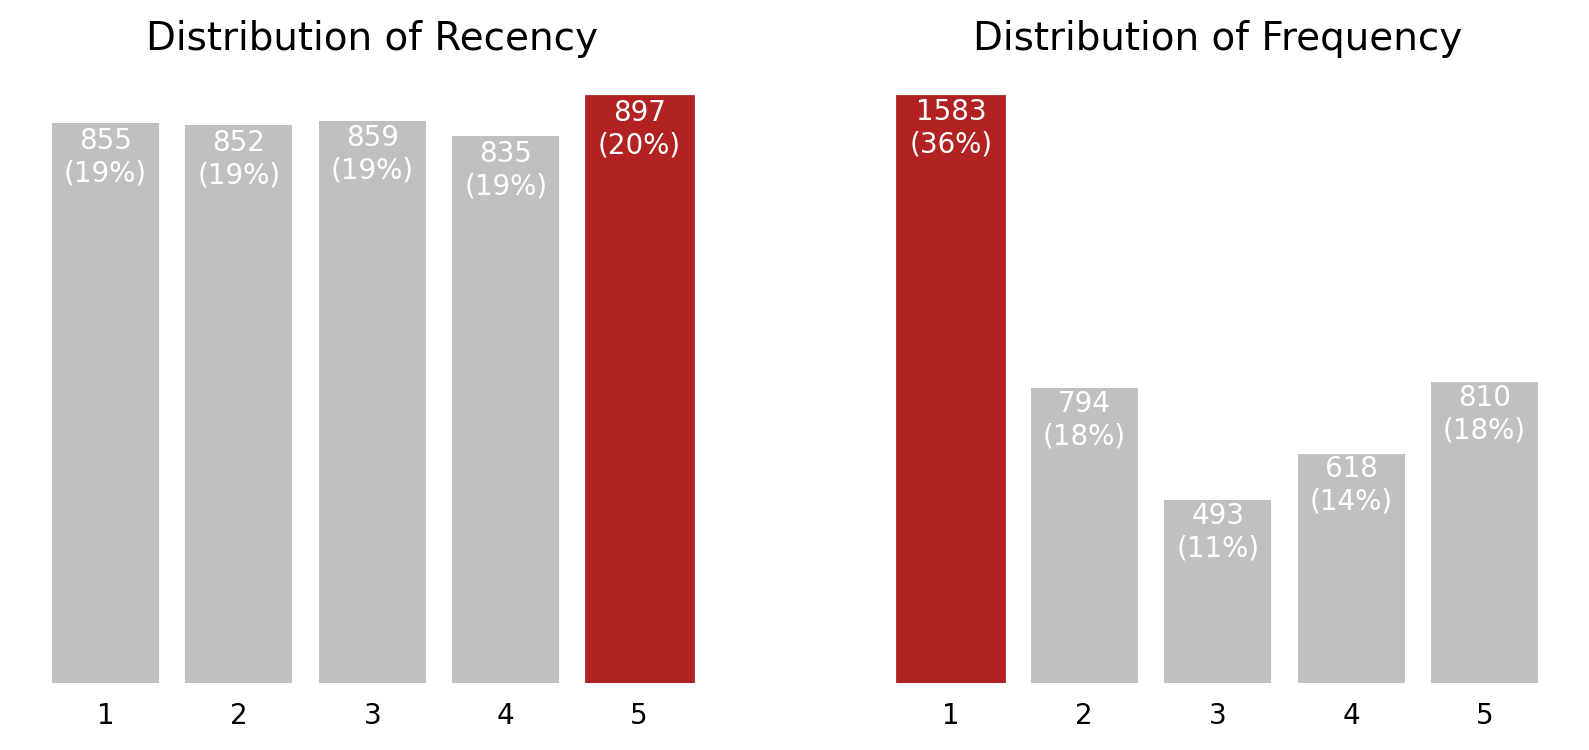

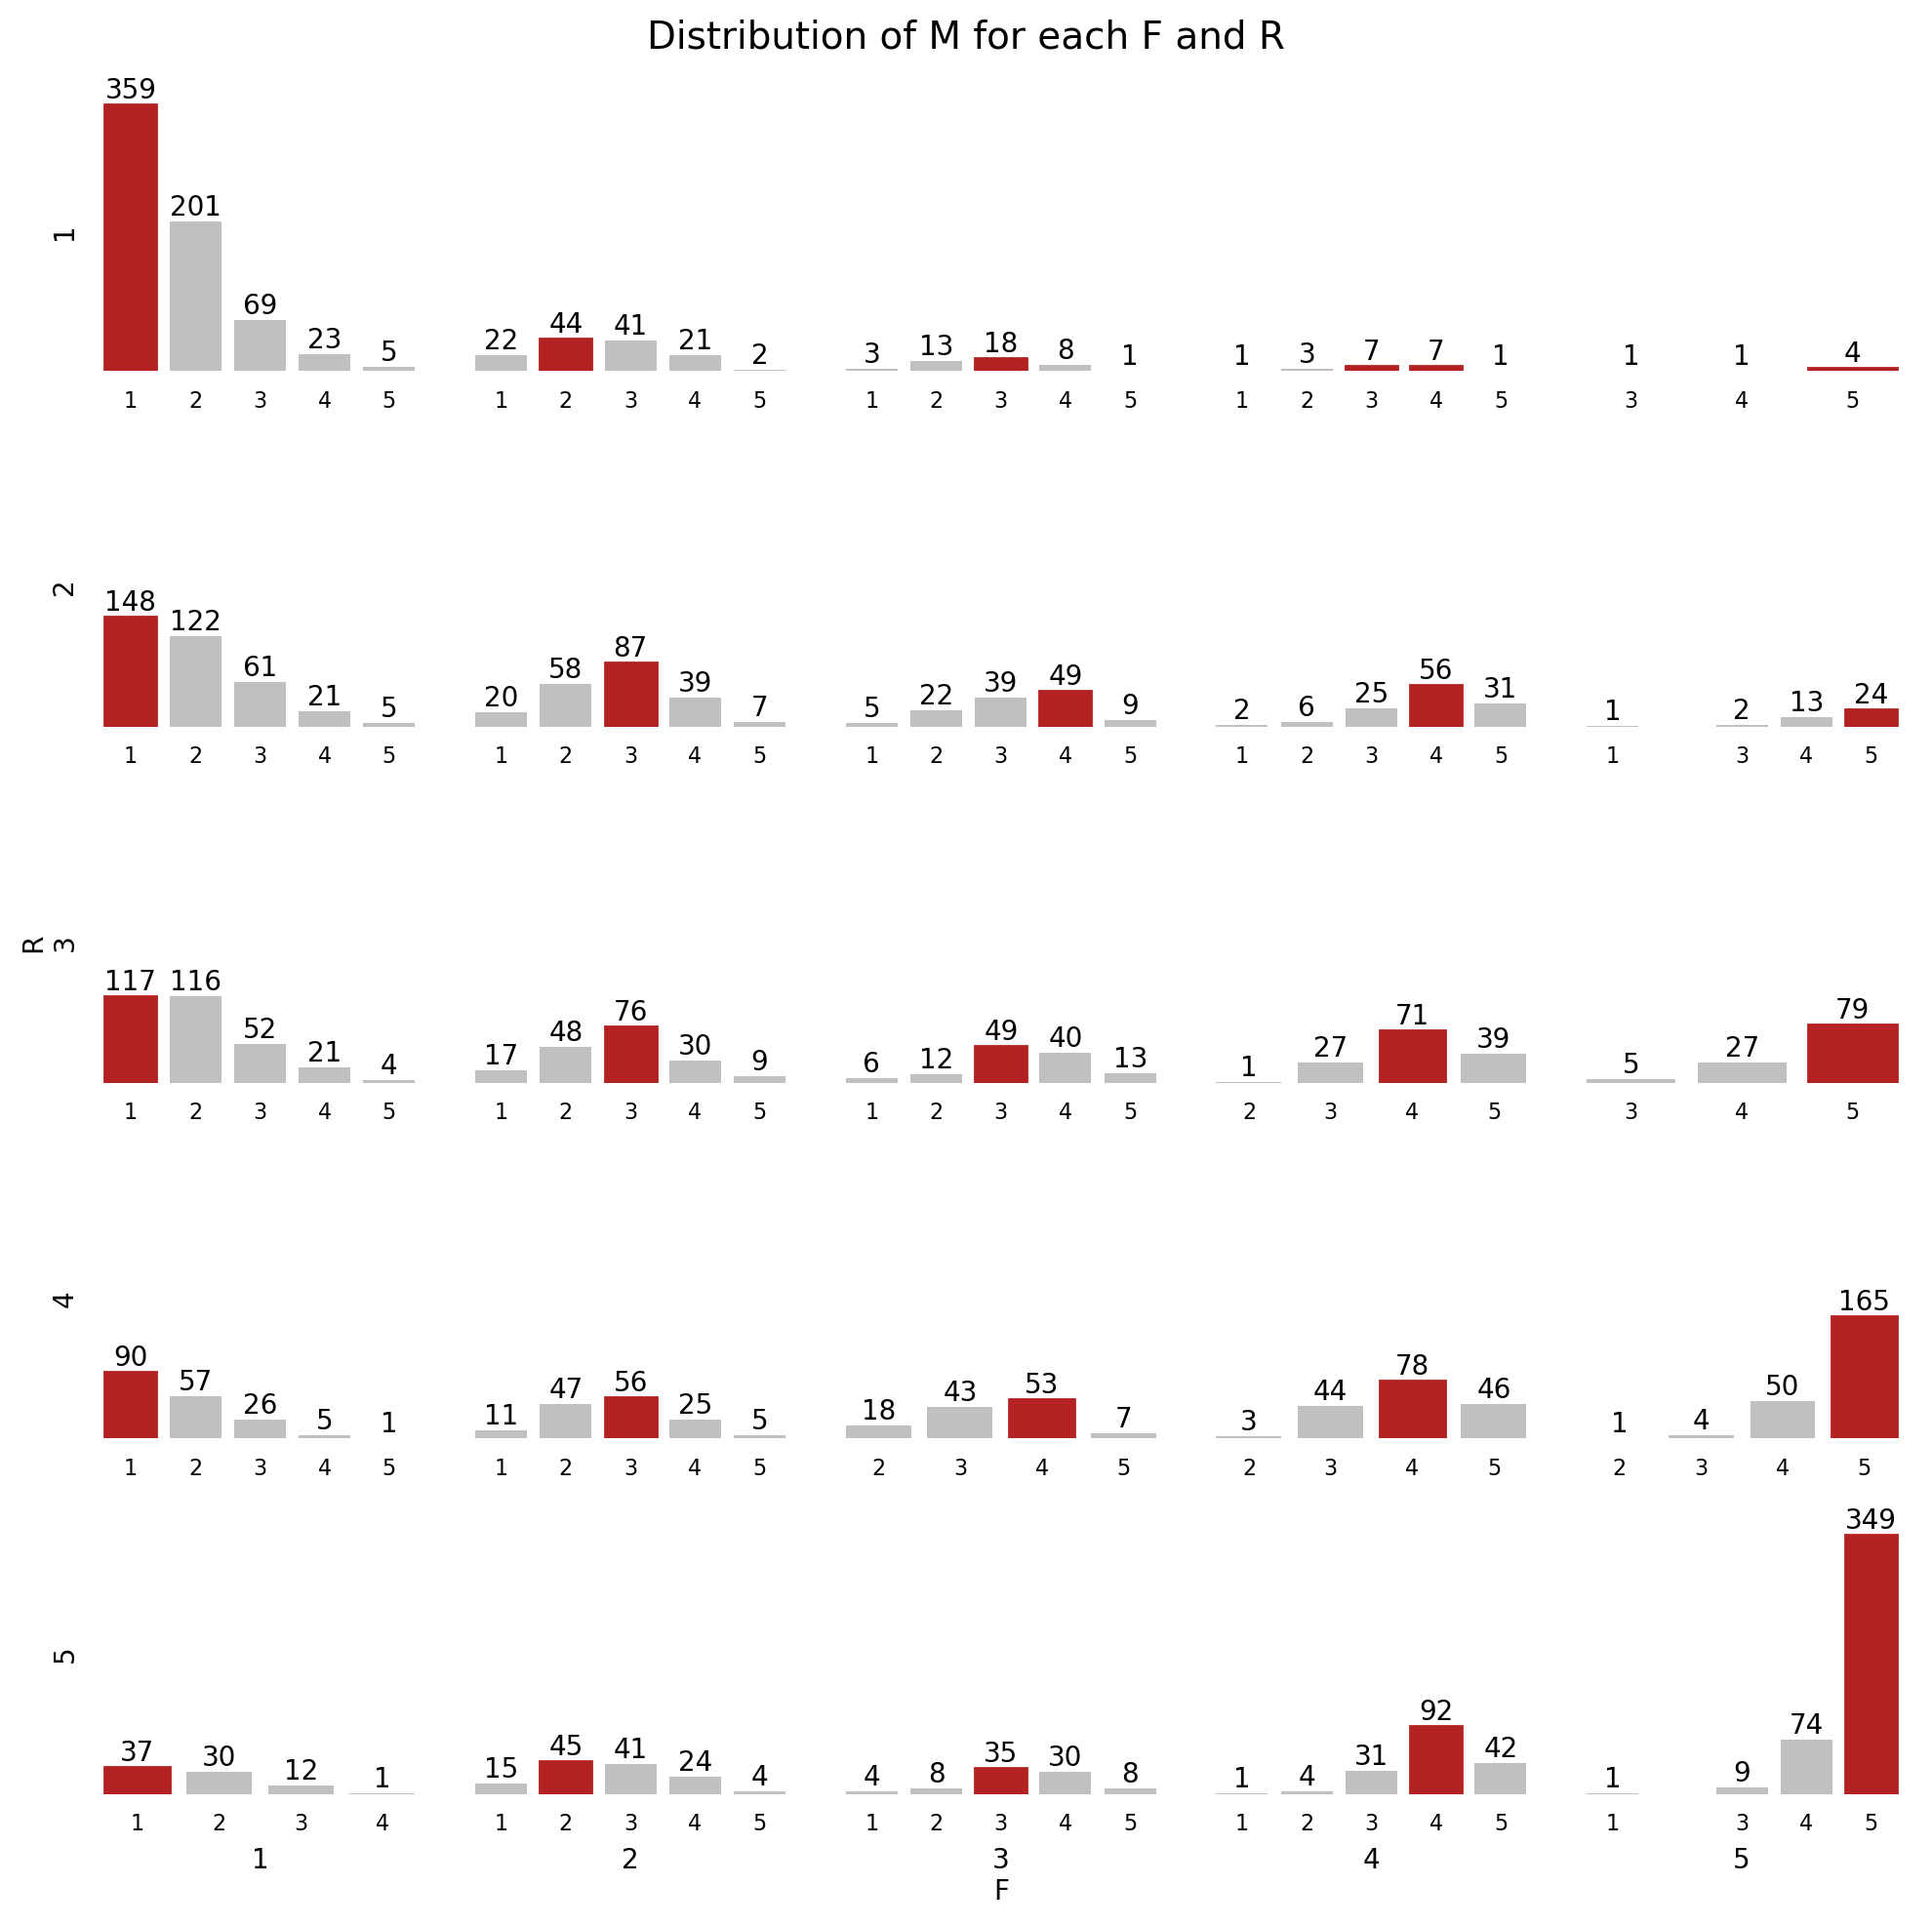

In [37]:
#plot the distribution of customers over R and F
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(['R', 'F']):
    parameters = {'R':'Recency', 'F':'Frequency'}
    y = rfm[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')

plt.show()

# plot the distribution of M for RF score
fig, axes = plt.subplots(nrows=5, ncols=5,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 6)
f_range = range(1, 6)
for r in r_range:
    for f in f_range:
        y = rfm[(rfm['R'] == r) & (rfm['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 5:
            if f == 3:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution of M for each F and R',
             fontsize=14)
plt.tight_layout()
plt.show()

We can see that if recency seems evenly distributed, almost half of the customers don't purchase very often (48% of customers have a frequency of 1 or 2).
When looking at the monetary value, we see that the customers spending the most are those with the highest activity (R and F of 4-5). We have very few large orders (high monetary value but low frequency).

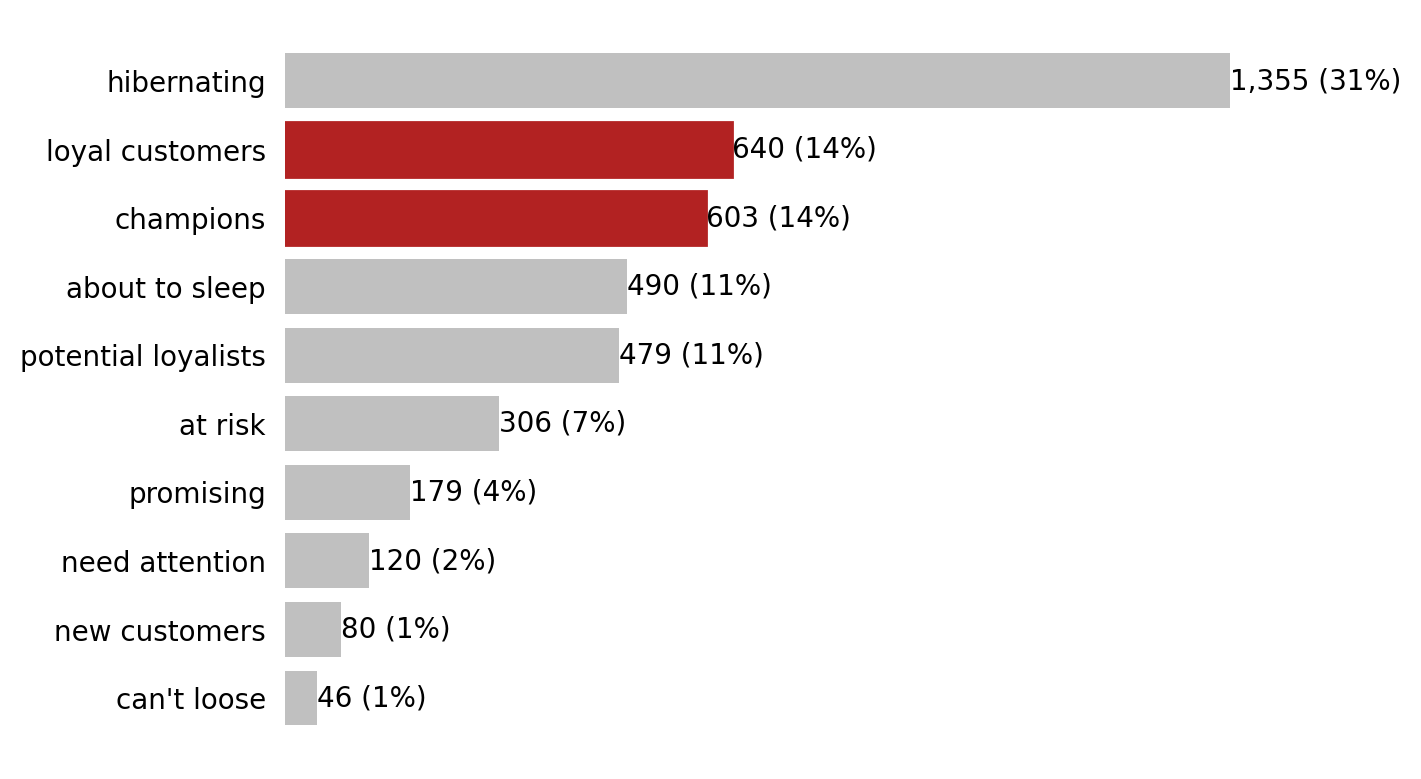

In [36]:
#count the number of customers in each segment
segments_counts = rfm['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['champions', 'loyal customers']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

We have a lot of customers who don't buy frequently from us (31% are hibernating). However, 28% of our customers are either champions or loyal customers.

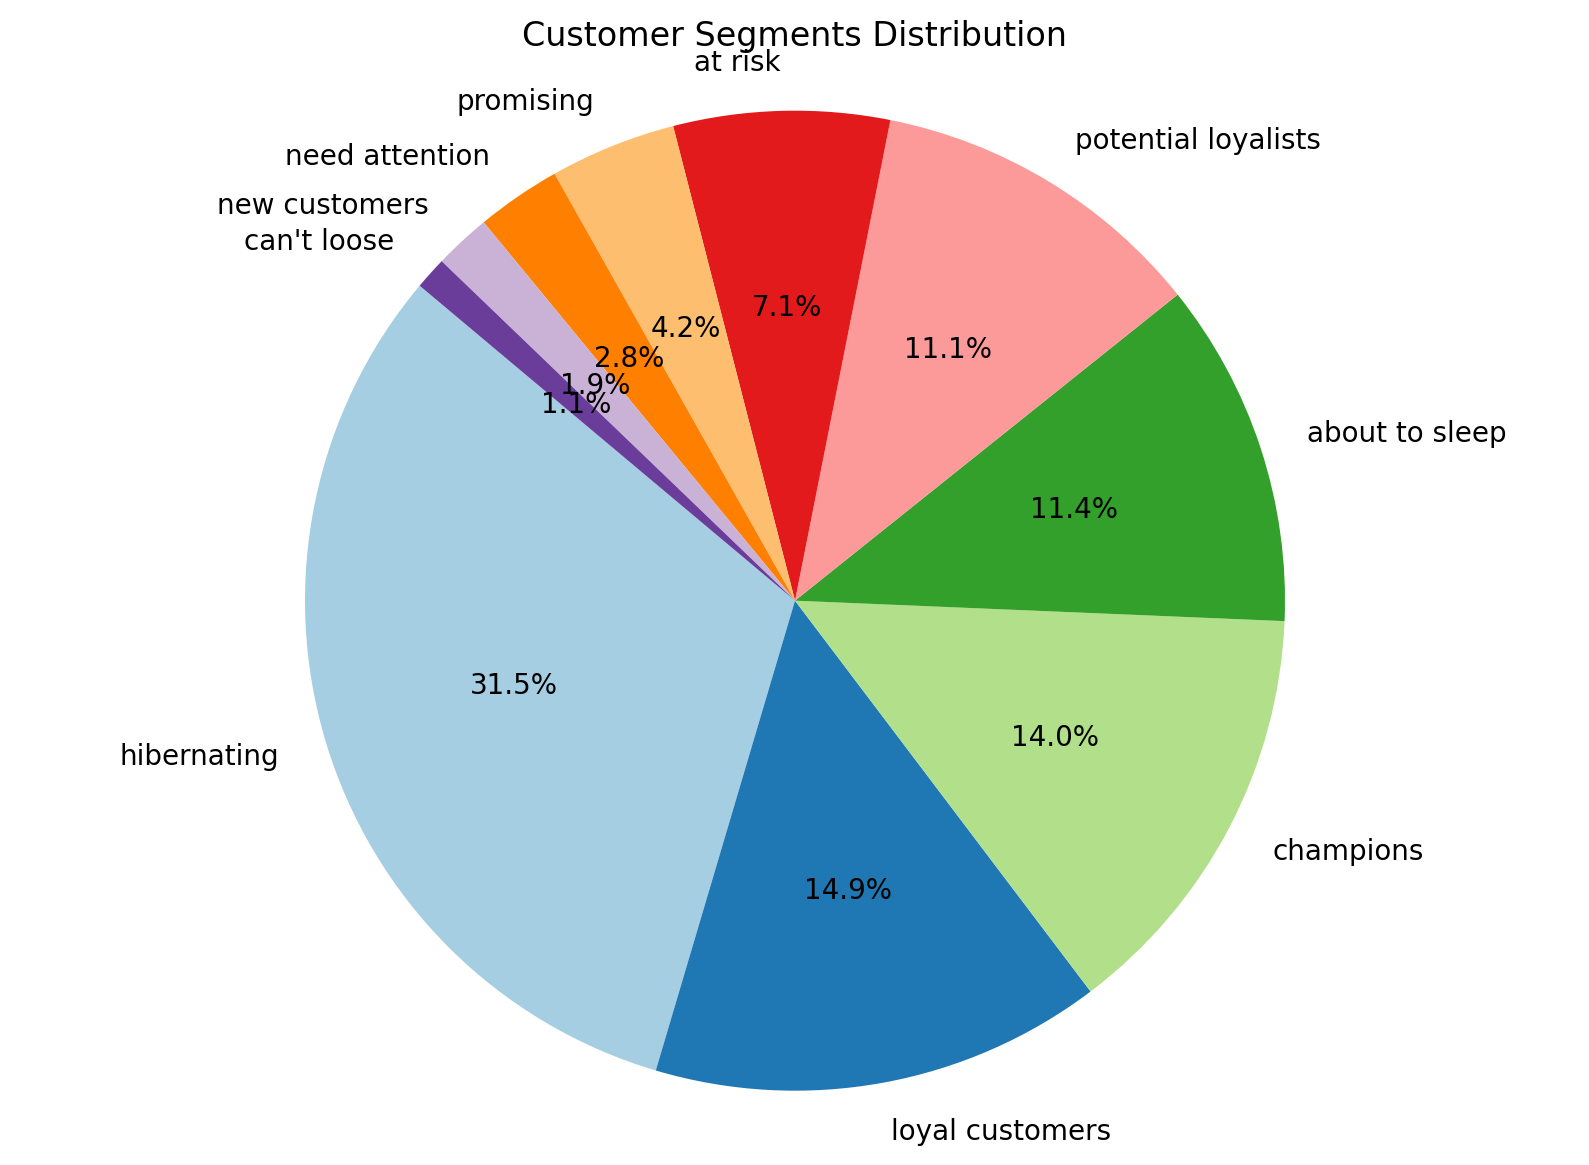

In [44]:
segments_counts = rfm['Segment'].value_counts()

# Plot the pie chart
fig, ax = plt.subplots(figsize=(10, 7))

ax.pie(segments_counts, labels=segments_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(segments_counts))))

# Ensure the pie chart is a circle
ax.axis('equal')

plt.title('Customer Segments Distribution')
plt.show()

### b) Conclude your findings of RFM analysis and suggest some strategies on it.

Customer Segmentation: Use the RFM segments to tailor marketing strategies and allocate resources effectively.

Customer Feedback: Regularly seek feedback to understand customer needs and improve service.

Data-Driven Decisions: Continuously analyze customer data to refine segments and strategies for better outcomes.